## Utilisation du dataset minst

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Charger dataset MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Préparer les données
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Création du modèle CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.summary()

# Compilation le modèle
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(x_train, y_train, epochs=5, batch_size=64,
                    validation_data=(x_test, y_test), verbose=1)

# Évaluation du modèle
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Précision sur MNIST : {test_accuracy:.2%}")

# Sauvegarde du modèle
model.save('mnist_base_model.h5')
print("Modèle sauvegardé sous 'mnist_base_model.h5'")

11490434/11490434 [==============================] - 3s 0us/step
Epoch 1/5
938/938 [==============================] - 24s 23ms/step - loss: 0.2324 - accuracy: 0.9302 - val_loss: 0.0503 - val_accuracy: 0.9837
Epoch 2/5
938/938 [==============================] - 20s 22ms/step - loss: 0.0793 - accuracy: 0.9764 - val_loss: 0.0354 - val_accuracy: 0.9880
Epoch 3/5
938/938 [==============================] - 26s 28ms/step - loss: 0.0581 - accuracy: 0.9830 - val_loss: 0.0309 - val_accuracy: 0.9895
Epoch 4/5
938/938 [==============================] - 22s 23ms/step - loss: 0.0475 - accuracy: 0.9856 - val_loss: 0.0256 - val_accuracy: 0.9902
Epoch 5/5
313/313 [==============================] - 3s 8ms/step - loss: 0.0243 - accuracy: 0.9919
Précision sur MNIST : 99.19%


c:\Master\Semestre 2\PI\Projet\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Modèle sauvegardé sous 'mnist_base_model.h5'


### Test du model cré avec le dataset minst

In [6]:
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image

# Charger le modèle une seule fois au niveau global
model = load_model('mnist_base_model.h5')

def predict_digit_from_image(image_path):
    """
    Prédit le chiffre sur une image binarisée (fond blanc, chiffre noir).
    :param image_path: chemin vers l'image
    :return: chiffre prédit (int)
    """
    # Charger et convertir l'image en niveaux de gris
    img = Image.open(image_path).convert('L')
    
    # Redimensionner à 28x28
    img = img.resize((28, 28))

    # Convertir en tableau numpy et normaliser
    img_array = np.array(img).astype('float32') / 255.0

    # Formater pour le modèle (1, 28, 28, 1)
    img_array = img_array.reshape(1, 28, 28, 1)

    # Prédire
    prediction = model.predict(img_array, verbose=0)
    predicted_digit = int(np.argmax(prediction))

    return predicted_digit

chemin_image = "image.png"
chiffre = predict_digit_from_image(chemin_image)
print(f"Chiffre prédit : {chiffre}")


Chiffre prédit : 6


### detection et extraction des positions

In [ ]:
import cv2
import json

positions = []

# Callback pour gérer les clics souris
def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        w, h = 28, 28  # Taille du ROI
        positions.append((x, y, w, h))
        print(f"Position enregistrée : x={x}, y={y}, w={w}, h={h}")
        cv2.rectangle(img_display, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.imshow(window_name, img_display)

# --- Charge l'image binarisée du décalque ---
image_path = "dataset_binarized/train/conformes/30mm_WonB_1_resized_copy1_copy1_copy1.jpg"
img = cv2.imread(image_path)

if img is None:
    raise FileNotFoundError(f"L'image '{image_path}' n'a pas été trouvée.")

img_display = img.copy()

# --- Crée une fenêtre redimensionnable ---
window_name = "Clique sur les chiffres"
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
cv2.imshow(window_name, img_display)
cv2.setMouseCallback(window_name, click_event)

print("🖱️ Clique sur chaque chiffre à extraire (ROI 28x28).")
print("❌ Appuie sur 'q' pour terminer et fermer.")

while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

# --- Sauvegarde les positions dans un fichier JSON ---
with open("positions_chiffres.json", "w") as f:
    json.dump(positions, f)

print("✅ Positions sauvegardées dans 'positions_chiffres.json'")


### Preparation des données : création des ROIS

In [ ]:
import cv2
import os
from pathlib import Path

# === PARAMÈTRES ===
input_folder = "dataset_binarized/train/non_conformes"        # Dossier avec tes images
output_folder = "roi_images"       # Dossier où les ROI seront enregistrés
coords_file = "coords.txt"     # Fichier avec les coordonnées des ROI
roi_size = (28, 28)            # Taille cible (optionnel : resize si nécessaire)

# === CRÉATION DES DOSSIERS OUTPUT ===
Path(output_folder).mkdir(parents=True, exist_ok=True)

# === LECTURE DES COORDONNÉES ===
with open(coords_file, "r") as f:
    coords = [tuple(map(int, line.strip().split(","))) for line in f]

# === TRAITEMENT DES IMAGES ===
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

for img_index, img_name in enumerate(image_files):
    img_path = os.path.join(input_folder, img_name)
    image = cv2.imread(img_path)

    if image is None:
        print(f"[❌] Image non chargée : {img_name}")
        continue

    for i, (x, y, w, h) in enumerate(coords):
        roi = image[y:y+h, x:x+w]
        roi_resized = cv2.resize(roi, roi_size)

        # Création d’un nom de fichier : imageIndex_roiIndex.jpg
        roi_filename = f"{Path(img_name).stem}_roi{i:02}.jpg"
        roi_path = os.path.join(output_folder, roi_filename)

        cv2.imwrite(roi_path, roi_resized)

    print(f"[✅] {img_name} → {len(coords)} ROI extraits")

print("\nExtraction terminée. Vérifie le dossier 'output'.")


### Labelisation des images 

In [ ]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import os
import shutil
from pathlib import Path

# === PARAMÈTRES ===
roi_folder = "roi_images"  # Dossier contenant les ROI à trier
conforme_folder = os.path.join(roi_folder, "conforme")
non_conforme_folder = os.path.join(roi_folder, "non_conforme")

# === CRÉATION DES DOSSIERS DE CLASSEMENT ===
Path(conforme_folder).mkdir(parents=True, exist_ok=True)
Path(non_conforme_folder).mkdir(parents=True, exist_ok=True)

# === LISTE DES IMAGES À TRIER ===
images = [f for f in os.listdir(roi_folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

# === INTERFACE ===
class TriROI:
    def __init__(self, master):
        self.master = master
        self.master.title("Interface de tri des ROI")
        self.index = 0
        self.image_label = tk.Label(master)
        self.image_label.pack()

        # Boutons
        btn_frame = tk.Frame(master)
        btn_frame.pack(pady=10)

        btn_c = tk.Button(btn_frame, text="✅ Conforme (C)", command=self.mark_conforme, width=20)
        btn_nc = tk.Button(btn_frame, text="❌ Non Conforme (N)", command=self.mark_non_conforme, width=20)
        btn_c.pack(side=tk.LEFT, padx=10)
        btn_nc.pack(side=tk.RIGHT, padx=10)

        # Raccourcis clavier
        master.bind("<c>", lambda e: self.mark_conforme())
        master.bind("<n>", lambda e: self.mark_non_conforme())

        self.show_image()

    def show_image(self):
        if self.index >= len(images):
            self.image_label.config(text="🎉 Tri terminé.")
            return

        img_path = os.path.join(roi_folder, images[self.index])
        image = Image.open(img_path)
        image = image.resize((200, 200))  # Resize pour affichage
        self.photo = ImageTk.PhotoImage(image)

        self.image_label.config(image=self.photo)
        self.image_label.image = self.photo

    def move_image(self, destination_folder):
        src = os.path.join(roi_folder, images[self.index])
        dst = os.path.join(destination_folder, images[self.index])
        shutil.move(src, dst)
        self.index += 1
        self.show_image()

    def mark_conforme(self):
        self.move_image(conforme_folder)

    def mark_non_conforme(self):
        self.move_image(non_conforme_folder)

# === LANCEMENT ===
if __name__ == "__main__":
    root = tk.Tk()
    app = TriROI(root)
    root.mainloop()


### Entrainement du model pour détecter un chiffre manquant

Epoch 1/10
38/38 [==============================] - 4s 33ms/step - loss: 0.1434 - accuracy: 0.9073 - val_loss: 0.0757 - val_accuracy: 0.9933
Epoch 2/10
38/38 [==============================] - 1s 21ms/step - loss: 0.0442 - accuracy: 0.9925 - val_loss: 0.0389 - val_accuracy: 0.9933
Epoch 3/10
38/38 [==============================] - 1s 22ms/step - loss: 0.0280 - accuracy: 0.9967 - val_loss: 0.0424 - val_accuracy: 0.9933
Epoch 4/10
38/38 [==============================] - 1s 23ms/step - loss: 0.0202 - accuracy: 0.9967 - val_loss: 0.0469 - val_accuracy: 0.9933
Epoch 5/10
38/38 [==============================] - 1s 20ms/step - loss: 0.0182 - accuracy: 0.9967 - val_loss: 0.0522 - val_accuracy: 0.9933
Epoch 6/10
38/38 [==============================] - 1s 20ms/step - loss: 0.0177 - accuracy: 0.9967 - val_loss: 0.0537 - val_accuracy: 0.9933
Epoch 7/10
38/38 [==============================] - 1s 18ms/step - loss: 0.0194 - accuracy: 0.9967 - val_loss: 0.0572 - val_accuracy: 0.9933
Epoch 8/10
38

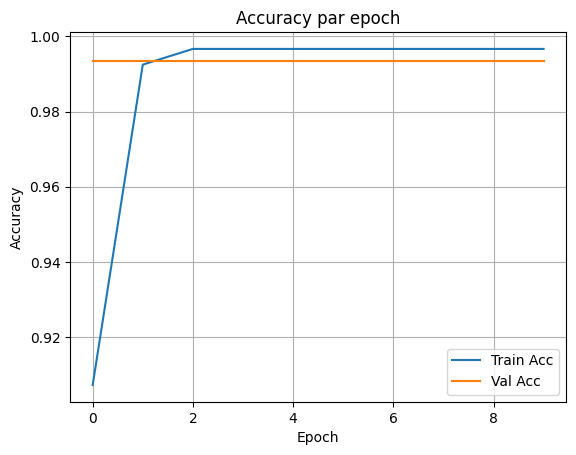

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# === PARAMÈTRES ===
img_size = 28
dataset_path = "roi_images"
classes = ["conforme", "non_conforme"]

# === CHARGEMENT DES IMAGES ===
X = []
y = []

for idx, label in enumerate(classes):
    class_folder = os.path.join(dataset_path, label)
    for file in os.listdir(class_folder):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(class_folder, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(idx)

X = np.array(X).reshape(-1, img_size, img_size, 1) / 255.0  # Normalisation
y = to_categorical(y, num_classes=2)

# === DIVISION TRAIN/TEST ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === MODELE CNN SIMPLE ===
model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 classes
])

# === COMPILATION ===
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# === ENTRAINEMENT ===
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# === EVALUATION ===
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {accuracy:.2%}")
model.save("cnn_conformite_model.h5")

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy par epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


### Extraction des roi en vue de test v1

In [4]:
import cv2
import os

# Chemin de l'image et du dossier de sortie
image_path = "dataset_binarized/train/conformes/30mm_WonB_1_resized_copy1_copy1_copy1.jpg"
output_dir = "uploads/extracted_rois"
coord_file = "coords.txt"

def extract_rois(image_path, output_dir, coord_file):
    # Charger l'image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"L'image '{image_path}' n'a pas été trouvée.")

    # Lire les coordonnées depuis le fichier
    with open(coord_file, "r") as f:
        coords = [tuple(map(int, line.strip().split(","))) for line in f]

    # Création du dossier de sortie s'il n'existe pas
    os.makedirs(output_dir, exist_ok=True)

    # Extraction et sauvegarde des ROI
    for i, (x, y, w, h) in enumerate(coords):
        roi = image[y:y+h, x:x+w]
        roi_filename = f"roi_{i:02}.jpg"
        roi_path = os.path.join(output_dir, roi_filename)
        cv2.imwrite(roi_path, roi)
        print(f"ROI {i} sauvegardé sous '{roi_path}'")

# Exécuter l'extraction
extract_rois(image_path, output_dir, coord_file)

ROI 0 sauvegardé sous 'uploads/extracted_rois\roi_00.jpg'
ROI 1 sauvegardé sous 'uploads/extracted_rois\roi_01.jpg'
ROI 2 sauvegardé sous 'uploads/extracted_rois\roi_02.jpg'
ROI 3 sauvegardé sous 'uploads/extracted_rois\roi_03.jpg'
ROI 4 sauvegardé sous 'uploads/extracted_rois\roi_04.jpg'
ROI 5 sauvegardé sous 'uploads/extracted_rois\roi_05.jpg'
ROI 6 sauvegardé sous 'uploads/extracted_rois\roi_06.jpg'
ROI 7 sauvegardé sous 'uploads/extracted_rois\roi_07.jpg'
ROI 8 sauvegardé sous 'uploads/extracted_rois\roi_08.jpg'
ROI 9 sauvegardé sous 'uploads/extracted_rois\roi_09.jpg'
ROI 10 sauvegardé sous 'uploads/extracted_rois\roi_10.jpg'
ROI 11 sauvegardé sous 'uploads/extracted_rois\roi_11.jpg'
ROI 12 sauvegardé sous 'uploads/extracted_rois\roi_12.jpg'
ROI 13 sauvegardé sous 'uploads/extracted_rois\roi_13.jpg'
ROI 14 sauvegardé sous 'uploads/extracted_rois\roi_14.jpg'
ROI 15 sauvegardé sous 'uploads/extracted_rois\roi_15.jpg'
ROI 16 sauvegardé sous 'uploads/extracted_rois\roi_16.jpg'
ROI 17 

### Test du model

In [5]:
import os
import sys
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# === PARAMÈTRES ===
IMG_SIZE = 28
MODEL_PATH = "cnn_conformite_model.h5"
CLASS_NAMES = ["conforme", "non_conforme"]

def load_and_prepare_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype("float32") / 255.0
    return img.reshape(1, IMG_SIZE, IMG_SIZE, 1)

def main(folder_path):
    # Charger le modèle
    model = load_model(MODEL_PATH)

    # Parcourir toutes les images
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepath = os.path.join(folder_path, filename)
            img_input = load_and_prepare_image(filepath)

            if img_input is None:
                print(f"{filename} : image non valide")
                continue

            prediction = model.predict(img_input, verbose=0)
            class_index = np.argmax(prediction)
            confidence = prediction[0][class_index]

            if CLASS_NAMES[class_index] == "non_conforme" and confidence < 0.9:

                print(f"{filename} ➤ {CLASS_NAMES[class_index]} ({confidence:.2%}) ⚠️")
            else : 
                print(f"{filename} ➤ {CLASS_NAMES[class_index]} ({confidence:.2%}) ")

folder_path = "uploads/extracted_rois"
if os.path.isdir(folder_path):
    main(folder_path)
else:
    print("Erreur : le dossier n'existe pas.")
        




roi_00.jpg ➤ conforme (100.00%) 
roi_01.jpg ➤ conforme (100.00%) 
roi_02.jpg ➤ conforme (99.89%) 
roi_03.jpg ➤ conforme (100.00%) 
roi_04.jpg ➤ conforme (99.72%) 
roi_05.jpg ➤ conforme (100.00%) 
roi_06.jpg ➤ conforme (99.99%) 
roi_07.jpg ➤ conforme (100.00%) 
roi_08.jpg ➤ non_conforme (94.32%) 
roi_09.jpg ➤ conforme (100.00%) 
roi_10.jpg ➤ conforme (100.00%) 
roi_11.jpg ➤ conforme (100.00%) 
roi_12.jpg ➤ conforme (100.00%) 
roi_13.jpg ➤ non_conforme (99.95%) 
roi_14.jpg ➤ conforme (100.00%) 
roi_15.jpg ➤ conforme (100.00%) 
roi_16.jpg ➤ conforme (100.00%) 
roi_17.jpg ➤ conforme (100.00%) 
roi_18.jpg ➤ conforme (99.98%) 
roi_19.jpg ➤ conforme (100.00%) 
roi_20.jpg ➤ conforme (100.00%) 
roi_21.jpg ➤ conforme (100.00%) 
roi_22.jpg ➤ conforme (100.00%) 
roi_23.jpg ➤ conforme (71.82%) 
roi_24.jpg ➤ conforme (100.00%) 
roi_25.jpg ➤ conforme (99.95%) 
roi_26.jpg ➤ conforme (100.00%) 
roi_27.jpg ➤ conforme (100.00%) 
roi_28.jpg ➤ conforme (100.00%) 
roi_29.jpg ➤ conforme (100.00%) 
roi_30.j